## Newsletter Agent의 노드 구축하기

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

### 사용자가 입력한 키워드에 대한 뉴스 검색 함수

In [2]:
from tavily import TavilyClient
from langchain_core.tools import tool

In [3]:
tavily_client = TavilyClient()


def search_recent_news(keyword):
    """
    This tool interacts with the Tavily AI API to search for recent news articles related to a given keyword.

    Args:
        keyword (str): The keyword or phrase to search for in the news articles.

    Returns:
        list:
        A list of titles, each containing up to 10 of the most recent news articles related to the keyword.
        - 'title' (str): The title of the news article.

    Example:
        response = search_news("OpenAI")
        # Returns a list of news articles published in the last day related to OpenAI.
    """
    article_info = []

    # Making the request to the Tavily API
    response = tavily_client.search(query=keyword, max_results=10, topic="news", days=7)
    title_list = [i["title"] for i in response["results"]]
    return title_list

In [4]:
keyword = "OpenAI"
result = search_recent_news(keyword)
result

['OpenAI Hits Pause on Open-Source Model: Safety First! - OpenTools',
 'Nearing its 10th anniversary, OpenAI is at a crossroads - Tech Brew',
 'OpenAI delays the release of its open model, again - TechCrunch',
 '$300 billion, 500 million users, and no time to enjoy it: The sharks are circling OpenAI - Business Insider Africa',
 "Microsoft's Existing OpenAI Deal May Be Undercutting Ad Agency Partnerships - Adweek",
 'OpenAI Hits Pause on Its Meta Killer - Gizmodo',
 'OpenAI tightens the screws on security to keep away prying eyes - TechCrunch',
 'Google scuppers $3bn OpenAI deal by buying key technology and developers - Gagadget.com',
 'Sam Altman says OpenAI is delaying its open-weight model to run extra safety tests - Business Insider',
 'ChatGPT keeps having more memories of you - Axios']

### 뉴스 테마 설정 함수

In [5]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [6]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)


# Data model
class NewsletterThemeOutput(BaseModel):
    """Output model for structured theme and sub-theme generation."""

    theme: str = Field(
        description="The main newsletter theme based on the provided article titles."
    )
    sub_themes: list[str] = Field(
        description="List of sub-themes or key news items to investigate under the main theme, ensuring they are specific and researchable."
    )


# LLM with function call
structured_llm_newsletter = llm.with_structured_output(NewsletterThemeOutput)

# Prompt
system = """
You are an expert helping to create a newsletter. 
Based on a list of article titles provided, your task is to choose a single, 
specific newsletter theme framed as a clear, detailed question that grabs the reader's attention. 

In addition, generate 5 sub-themes that are highly specific, researchable news items or insights under the main theme. 
Ensure these sub-themes reflect the latest trends in the field and frame them as compelling news topics.

The output should be formatted as:
- Main theme (in question form)
- 3-5 sub-themes (detailed and focused on emerging trends, technologies, or insights).

The sub-themes should create a clear direction for the newsletter, avoiding broad, generic topics.
All your output should be in Korean

"""

# This is the template that will feed into the structured LLM
theme_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Article titles: \n\n {article_titles}"),
    ]
)

# Chain together the system prompt and the structured output model
newsletter_generator = theme_prompt | structured_llm_newsletter

In [7]:
output = newsletter_generator.invoke({"article_titles": result})
subthemes = output.sub_themes
subthemes

['OpenAI의 오픈소스 모델 연기와 그 배경: 안전 우선 정책의 실체 확인',
 'OpenAI의 10주년을 맞이한 현재 상황: 변화하는 시장의 요구와 전략',
 'Microsoft와 OpenAI 간의 파트너십 문제: 광고 대행사와의 갈등 분석',
 '구글의 OpenAI 기술 인수: AI 경쟁 구도가 어떻게 달라질 것인가?',
 'OpenAI의 보안 강화 조치: 사용자 데이터 보호를 위한 새로운 기술과 접근 방식']

In [8]:
from typing import List


def subtheme_generator(recent_news: List[str]):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=1)

    # Data model
    class NewsletterThemeOutput(BaseModel):
        """Output model for structured theme and sub-theme generation."""

        theme: str = Field(
            description="The main newsletter theme based on the provided article titles."
        )
        sub_themes: list[str] = Field(
            description="List of sub-themes or key news items to investigate under the main theme, ensuring they are specific and researchable."
        )

    # LLM with function call
    structured_llm_newsletter = llm.with_structured_output(NewsletterThemeOutput)

    # Prompt
    system = """
    You are an expert helping to create a newsletter. Based on a list of article titles provided, your task is to choose a single, 
    specific newsletter theme framed as a clear, detailed question that grabs the reader's attention. 

    In addition, generate 3 to 5 sub-themes that are highly specific, researchable news items or insights under the main theme. 
    Ensure these sub-themes reflect the latest trends in the field and frame them as compelling news topics.

    The output should be formatted as:
    - Main theme (in question form)
    - 3-5 sub-themes (detailed and focused on emerging trends, technologies, or insights).

    The sub-themes should create a clear direction for the newsletter, avoiding broad, generic topics.
    All your output should be in Korean

    """

    # This is the template that will feed into the structured LLM
    theme_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Article titles: \n\n {recent_news}"),
        ]
    )

    # Chain together the system prompt and the structured output model
    subtheme_chain = theme_prompt | structured_llm_newsletter
    output = subtheme_chain.invoke({"recent_news": recent_news})
    return output

In [9]:
output = subtheme_generator({"article_titles": result})
subthemes = output.sub_themes
output

NewsletterThemeOutput(theme='OpenAI의 안전성 확보: 혁신과 리스크 사이에서 우리는 무엇을 배울 수 있을까?', sub_themes=['OpenAI의 오픈소스 모델 출시 지연 배경과 그로 인한 업계 반응 분석', '전 세계에서 OpenAI와 상호작용하는 5억 사용자 트렌드 및 기업의 활용 방안 탐구', '마이크로소프트의 오픈AI 계약이 광고 대행사와의 파트너십에 미치는 영향 연구', 'OpenAI의 보안 강화 조치가 AI 모델의 개발 및 배포에 미치는 장기적인 효과', 'Google이 OpenAI의 거래를 방해하며 취한 최신 기술 전략과 그로 인해 예상되는 시장 변화'])

### 세부 뉴스를 비동기로 검색하는 함수

In [10]:
import asyncio
from tavily import AsyncTavilyClient

# tavily_client는 AsyncTavilyClient의 인스턴스
async_tavily_client = AsyncTavilyClient()


async def search_news_for_subtheme(subtheme):
    """
    각 subtheme에 대한 비동기 Tavily API 검색.
    """
    response = await async_tavily_client.search(
        query=subtheme,
        max_results=5,
        topic="news",
        days=7,
        include_images=True,  # 이미지 포함
        include_raw_content=True,  # 원본 콘텐츠 포함
    )

    # 각 기사에 맞는 제목, 이미지, 내용 추출
    images = response["images"]
    results = response["results"]

    article_info = []
    for i, result in enumerate(results):
        article_info.append(
            {
                "title": result["title"],
                "image_url": images[i],
                "raw_content": result["raw_content"],
            }
        )

    return {subtheme: article_info}


async def search_news_by_subthemes(subthemes):
    """
    여러 subtheme에 대한 뉴스를 비동기로 병렬 검색.
    """
    # asyncio.gather를 사용해 여러 비동기 작업 병렬 처리
    results = await asyncio.gather(
        *[search_news_for_subtheme(subtheme) for subtheme in subthemes]
    )

    search_results = {}
    for result in results:
        search_results.update(result)

    return search_results

In [11]:
subtheme_search_results = await search_news_by_subthemes(subthemes)
subtheme_search_results

{'OpenAI의 오픈소스 모델 출시 지연 배경과 그로 인한 업계 반응 분석': [{'title': 'OpenAI Hits Pause on Open-Source Model: Safety First! - OpenTools',
   'image_url': 'https://images.roa.ai/articles/2023/02/eb2160f6-a5e8-11ed-8a13-0a58a9feac02.png',
   'raw_content': "Published Time: 2025-07-12T11:32:19.215Z\n\nOpenAI Hits Pause on Open-Source Model: Safety First! | AI News\n\n===============\n\n[OpenTools![Image 1: logo](https://opentools.ai/opentools-logo-red-light.svg)](https://opentools.ai/)\n\nOpen main menu\n\n[Newsletter](https://newsletter.opentools.ai/subscribe?utm_medium=content-header&utm_source=website)[News](https://opentools.ai/news)[Submit A Tool](https://opentools.ai/friends/launch-tool)[Advertise](https://forms.gle/cttiR9SNE8Xv8Sik8)\n\nCategories\n\nGet started\n\n[Learn to use AI like a Pro. Learn More](https://newsletter.opentools.ai/upgrade?offer_id=2b8eeb73-4d02-4137-a782-2a706cd1d187&utm_medium=content-header&utm_source=website)\n\n[OpenTools![Image 2: logo](https://opentools.ai/opentools

### 본문 작성 함수

In [12]:
import asyncio
from typing import Dict, List, TypedDict, Annotated
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages


def merge_dicts(left: Dict, right: Dict) -> Dict:
    return {**left, **right}


class State(TypedDict):
    keyword: str
    article_titles: List[str]
    newsletter_theme: NewsletterThemeOutput
    sub_theme_articles: Dict[str, List[Dict]]
    results: Annotated[Dict[str, str], merge_dicts]
    messages: Annotated[List, add_messages]

In [13]:
def write_newsletter_section(state: State, sub_theme: str) -> Dict:
    articles = state["sub_theme_articles"][sub_theme]

    # Prepare a list of formatted article references including title, image, and a snippet of raw content
    article_references = "\n".join(
        [
            f"Title: {article['title']}\nContent: {article['raw_content']}..."
            for article in articles
        ]
    )

    prompt = f"""
    Write a newsletter section for the sub-theme: "{sub_theme}".
    
    Use the following articles as reference and include relevant points from both their titles, images, and content:
    <article>
    {article_references}
    <article/>
    Summarize the key points and trends related to this sub-theme, and ensure you reference the images where they add value to the discussion. 
    Keep the tone engaging and informative for newsletter readers. You should write in Korean
    """

    messages = [HumanMessage(content=prompt)]
    response = llm.invoke(messages)
    return {"results": {sub_theme: response.content}}


def write_newsletter_section_async(state: State, sub_theme: str) -> Dict:
    return asyncio.run(write_newsletter_section(state, sub_theme))

테스트 

In [14]:
test_state = {
    "sub_theme_articles": {
        "AI Technology": [
            {
                "title": "OpenAI Releases GPT-4 Update",
                "raw_content": """OpenAI has announced a significant update to its GPT-4 model, 
                bringing improvements in reasoning and coding capabilities. The new version shows 
                enhanced performance across various benchmarks and demonstrates better ability 
                to handle complex instructions.""",
            },
            {
                "title": "AI in Healthcare Makes Breakthrough",
                "raw_content": """A new AI system has demonstrated remarkable accuracy in early 
                disease detection, potentially revolutionizing preventive healthcare. The system, 
                developed by leading researchers, shows promise in identifying early signs of 
                various conditions.""",
            },
        ]
    },
    "results": {},
}
write_newsletter_section(test_state, "AI Technology")

{'results': {'AI Technology': '### AI 기술 뉴스레터 섹션\n\n안녕하세요, 테크 팬 여러분! 이번 주 AI 기술 관련 소식을 전해드리겠습니다. \n\n**1. OpenAI의 GPT-4 업데이트 출시**\nOpenAI가 최신 버전의 GPT-4 모델을 공개했습니다. 이 업데이트는 추론 및 코딩 능력에서 눈에 띄는 향상을 보여주고 있으며, 다양한 벤치마크에서 성능이 크게 개선되었습니다. 특히, 복잡한 지시를 처리하는 능력이 향상되어 더욱 정교한 자연어 처리(NLP)를 필요로 하는 응용 프로그램에 적합합니다. 업데이트 발표와 함께 공개된 이미지에서는 새로운 모델의 하드웨어 구조와 학습 과정이 시각적으로 보여져, 기술적인 깊이를 더해줍니다.\n\n**2. 의료 분야에서의 AI 혁신**\nAI 기술이 의료 분야에서 뚜렷한 breakthroughs를 이루고 있습니다. 최근 개발된 새로운 AI 시스템이 질병 조기 발견에서 놀라운 정확성을 보여주었으며, 이는 예방 의료 분야에서 혁신을 일으킬 잠재력을 가지고 있습니다. 이 시스템은 다양한 질병의 초기 신호를 식별하는 데 효과적이며, 전문가들이 제공한 이미지에서는 진단 과정에서 AI의 역할을 어떻게 활용할 수 있는지를 명확히 보여주고 있습니다.\n\n### 종합적으로 살펴보기\n이번 주 AI 기술에서는 OpenAI의 최신 GPT-4 업데이트와 의료 분야에서의 AI breakthrough가 주목받고 있습니다. AI는 다양한 분야에서 우리의 삶을 더욱 편리하고 안전하게 만들어 갈 준비를 하고 있으며, 앞으로의 발전이 기대됩니다. 저희의 다음 뉴스레터에서도 새로운 돌파구와 혁신에 대한 소식을 계속해서 전해드리겠습니다!'}}

### 그래프 구축

In [15]:
import asyncio
from typing import Dict, List, TypedDict, Annotated
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages
import operator
from tavily import TavilyClient
import os

In [16]:
# 동기 함수들
def search_keyword_news(state: State) -> State:
    keyword = state["keyword"]
    article_titles = search_recent_news(keyword)
    return {"article_titles": article_titles}


def generate_newsletter_theme(state: State) -> State:
    article_titles = state["article_titles"]
    newsletter_theme = newsletter_generator.invoke(
        {"article_titles": "\n".join(article_titles)}
    )
    newsletter_theme.sub_themes = newsletter_theme.sub_themes[:5]
    return {"newsletter_theme": newsletter_theme}


async def search_news_for_subtheme(subtheme):
    async_tavily_client = AsyncTavilyClient()
    response = await async_tavily_client.search(
        query=subtheme,
        max_results=5,
        topic="news",
        days=1,
        include_images=True,
        include_raw_content=True,
    )
    images = response["images"]
    results = response["results"]

    article_info = []
    for i, result in enumerate(results):
        article_info.append(
            {
                "title": result["title"],
                "image_url": images[i],
                "raw_content": result["raw_content"],
            }
        )

    return {subtheme: article_info}


async def search_sub_theme_articles(state: State) -> State:
    subthemes = state["newsletter_theme"].sub_themes
    results = await asyncio.gather(
        *[search_news_for_subtheme(subtheme) for subtheme in subthemes]
    )

    sub_theme_articles = {}
    for result in results:
        sub_theme_articles.update(result)

    return {"sub_theme_articles": sub_theme_articles}


async def write_newsletter_section_async(state: State, sub_theme: str) -> Dict:
    articles = state["sub_theme_articles"][sub_theme]

    # Prepare a list of formatted article references including title, image, and a snippet of raw content
    article_references = "\n".join(
        [
            f"Title: {article['title']}\nContent: {article['raw_content']}..."
            for article in articles
        ]
    )

    prompt = f"""
    Write a newsletter section for the sub-theme: "{sub_theme}".
    
    Use the following articles as reference and include relevant points from both their titles, images, and content:
    <article>
    {article_references}
    <article/>
    Summarize the key points and trends related to this sub-theme, and ensure you reference the images where they add value to the discussion. 
    Keep the tone engaging and informative for newsletter readers. You should write in Korean
    """

    messages = [HumanMessage(content=prompt)]
    response = await llm.ainvoke(messages)
    return {"results": {sub_theme: response.content}}


# def write_newsletter_section(state: State, sub_theme: str) -> Dict:
#     return asyncio.run(write_newsletter_section_async(state, sub_theme))


def aggregate_results(state: State) -> State:
    theme = state["newsletter_theme"].theme
    combined_newsletter = f"# {theme}\n\n"
    for sub_theme, content in state["results"].items():
        combined_newsletter += f"## {sub_theme}\n{content}\n\n"
    return {
        "messages": [
            HumanMessage(content=f"Generated Newsletter:\n\n{combined_newsletter}")
        ]
    }


def edit_newsletter(state: State) -> State:
    theme = state["newsletter_theme"].theme
    combined_newsletter = state["messages"][-1].content

    prompt = f"""
    As an expert editor, review and refine the following newsletter on the theme: {theme}

    {combined_newsletter}

    Please ensure:
    0. Title should be in question form. subtitles are free to make question or just sentence.
    1. Consistent tone and style throughout the newsletter
    2. Smooth transitions between sections
    3. Proper formatting and structure
    4. Clear and engaging language
    5. No grammatical or spelling errors

    Provide the edited version of the newsletter.
    """

    messages = [HumanMessage(content=prompt)]
    writer_llm = ChatOpenAI(model="gpt-4o-mini", temperature=1, max_tokens=8192)
    response = writer_llm.invoke(messages)  # 'ainvoke'를 'invoke'로 변경

    return {
        "messages": [HumanMessage(content=f"Edited Newsletter:\n\n{response.content}")]
    }

In [17]:
# LangGraph 구성
workflow = StateGraph(State)
workflow.add_node("editor", edit_newsletter)
# 노드 추가
workflow.add_node("search_news", search_keyword_news)
workflow.add_node("generate_theme", generate_newsletter_theme)
workflow.add_node("search_sub_themes", search_sub_theme_articles)
workflow.add_node("aggregate", aggregate_results)

workflow.add_edge("aggregate", "editor")
workflow.add_edge("editor", END)

for i in range(5):
    node_name = f"write_section_{i}"
    workflow.add_node(
        node_name,
        lambda s, i=i: write_newsletter_section(s, s["newsletter_theme"].sub_themes[i]),
    )

# 엣지 연결
workflow.add_edge(START, "search_news")
workflow.add_edge("search_news", "generate_theme")
workflow.add_edge("generate_theme", "search_sub_themes")
for i in range(5):
    workflow.add_edge("search_sub_themes", f"write_section_{i}")
    workflow.add_edge(f"write_section_{i}", "aggregate")

# 그래프 컴파일
graph = workflow.compile()

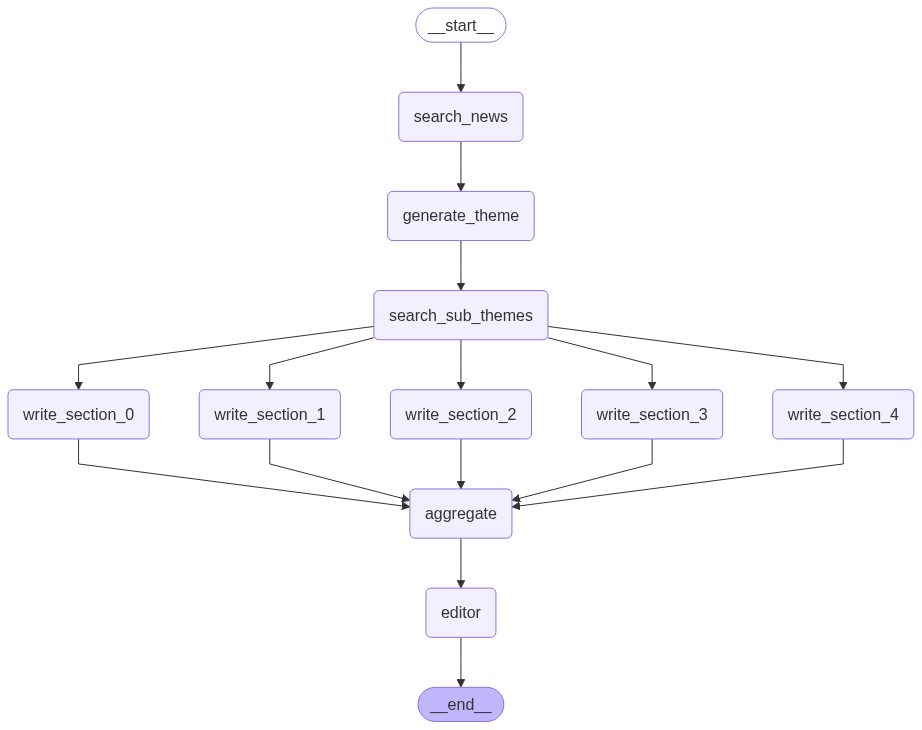

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
keyword = input("Enter a keyword for the newsletter: ")

inputs = {"keyword": keyword}
async for output in graph.astream(inputs, stream_mode="updates"):
    # stream_mode="updates" yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(print(value))
    print("\n---\n")

Output from node 'search_news':
---
{'article_titles': ['OpenAI Hits Pause on Open-Source Model: Safety First! - OpenTools', 'Nearing its 10th anniversary, OpenAI is at a crossroads - Tech Brew', 'OpenAI delays the release of its open model, again - TechCrunch', '$300 billion, 500 million users, and no time to enjoy it: The sharks are circling OpenAI - Business Insider Africa', "Microsoft's Existing OpenAI Deal May Be Undercutting Ad Agency Partnerships - Adweek", 'OpenAI Hits Pause on Its Meta Killer - Gizmodo', 'OpenAI tightens the screws on security to keep away prying eyes - TechCrunch', 'Google scuppers $3bn OpenAI deal by buying key technology and developers - Gagadget.com', 'Sam Altman says OpenAI is delaying its open-weight model to run extra safety tests - Business Insider', 'ChatGPT keeps having more memories of you - Axios']}
None

---

Output from node 'generate_theme':
---
{'newsletter_theme': NewsletterThemeOutput(theme='OpenAI의 현재 상황과 미래 방향은 어떻게 될 것인가?', sub_themes=['Ope